In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, iirnotch

# Load & Preprocessing

In [15]:
# Paths
DATA_DIR = os.path.join(os.getcwd(),"data")
OUTPUT_DIR = "processed_spectrograms"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Corrected EEG Channel Mapping for Muse 2
EEG_CHANNELS = {
    "TP9": "TP9",   # Left temporal
    "AF7": "Fp1",   # Left frontal
    "AF8": "Fp2",   # Right frontal
    "TP10": "TP10"  # Right temporal
}

In [19]:
# Band-pass filter (3-30Hz)
def bandpass_filter(data, lowcut=3, highcut=30, fs=256, order=4):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)

# Notch filter (50Hz)
def notch_filter(data, notch_freq=50, fs=256, quality=30):
    b, a = iirnotch(notch_freq / (fs / 2), quality)
    return filtfilt(b, a, data, axis=0)

# Compute STFT Spectrogram
def compute_stft(data, fs=256, nperseg=256, noverlap=128):
    spectrograms = []
    for channel in range(data.shape[1]):
        f, t, Sxx = signal.spectrogram(data[:, channel], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spectrograms.append(Sxx)
    return np.array(spectrograms)

# Normalize using Z-score
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Save Spectrogram as Image
def save_spectrograms(spectrograms, filename, label):
    output_folder = os.path.join(OUTPUT_DIR, label)
    os.makedirs(output_folder, exist_ok=True)

    for i, spec in enumerate(spectrograms):
        plt.figure(figsize=(6, 4))
        plt.imshow(10 * np.log10(spec + 1e-10), aspect="auto", cmap="jet")
        plt.colorbar()
        plt.title(f"Channel {list(EEG_CHANNELS.values())[i]} Spectrogram")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.savefig(os.path.join(output_folder, f"{filename}_channel_{list(EEG_CHANNELS.values())[i]}.png"))
        plt.close()

In [20]:
# Load EEG Data with Corrected Column Names
def load_eeg_data(csv_file):
    """Loads EEG data from a CSV file and renames columns."""
    df = pd.read_csv(csv_file)

    # Rename columns to match expected format
    df = df.rename(columns=EEG_CHANNELS)
    
    # Ensure required columns exist
    missing_columns = [ch for ch in EEG_CHANNELS.values() if ch not in df.columns]
    if missing_columns:
        print(f"⚠️ Skipping {csv_file}, missing columns: {missing_columns}")
        return None, None

    return df[list(EEG_CHANNELS.values())].values, df["timestamps"].values

# Process a single EEG file
def process_file(csv_path, label):
    filename = os.path.basename(csv_path).split(".")[0]
    
    # Load EEG data
    eeg_data, timestamps = load_eeg_data(csv_path)
    if eeg_data is None:
        return  # Skip files with missing EEG columns

    # Apply filtering and preprocessing
    eeg_data = bandpass_filter(eeg_data)
    eeg_data = notch_filter(eeg_data)
    eeg_data = normalize_data(eeg_data)
    spectrograms = compute_stft(eeg_data)

    # Save spectrogram images
    save_spectrograms(spectrograms, filename, label)

# Process all files in "true" and "false" folders
def process_all():
    for label in ["true", "false"]:
        folder_path = os.path.join(DATA_DIR, label)
        if not os.path.exists(folder_path):
            print(f"⚠️ Skipping missing folder: {folder_path}")
            continue

        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(folder_path, file)
                process_file(file_path, label)

In [21]:
# Run the pipeline
process_all()

print("Processing complete! Check the 'processed_spectrograms' folder for results.")

Processing complete! Check the 'processed_spectrograms' folder for results.


# Model Training

In [43]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [48]:
# Paths to spectrograms
DATASET_DIR = "processed_spectrograms"

# Image Parameters
IMG_SIZE = (224, 224)  # Resize images to match EfficientNet input size
BATCH_SIZE = 16
EPOCHS = 20

In [49]:
# Load Dataset
def load_data():
    images, labels = [], []
    label_map = {"true": 0, "false": 1}  # Mapping for classification

    for label in ["true", "false"]:
        folder_path = os.path.join(DATASET_DIR, label)
        if not os.path.exists(folder_path):
            print(f"⚠️ Skipping missing folder: {folder_path}")
            continue

        for file in os.listdir(folder_path):
            if file.endswith(".png"):
                img_path = os.path.join(folder_path, file)
                img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
                img_array = keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label_map[label])

    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels


In [50]:
# Load and split data
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights (optional, for imbalanced data)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [51]:
# Build CNN Model (Using EfficientNetV2-S)
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification (true/false)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [52]:
# Step 1: Train frozen model (feature extraction phase)
history = model.fit(train_generator, epochs=EPOCHS, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Step 2: Unfreeze deeper layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Step 3: Recompile model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
              loss="binary_crossentropy", metrics=["accuracy"])

# Step 4: Continue training with fine-tuning
history_finetune = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test), class_weight=class_weights_dict)

c:\Users\Ilian\OneDrive\Documents\GH_Projects\EEG_Lie_Detector\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 68s 18s/step - accuracy: 0.2083 - loss: 0.7062 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5833 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6979
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3125 - loss: 0.7024 - val_accuracy: 0.5000 - val_loss: 0.6976
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4167 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4792 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6961
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4583 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6042 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 0.6879 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 9/20
2/2

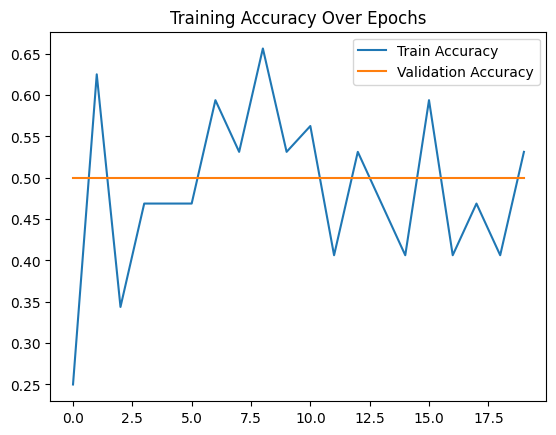

✅ Model training complete! Model saved as 'eeg_lie_detector.h5'.


In [53]:
# Save model
model.save("models/eeg_lie_detector%s.keras" %time.strftime('%Y-%m-%H.%M.%S', time.localtime()))

# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training Accuracy Over Epochs")
plt.show()

print("✅ Model training complete! Model saved as 'eeg_lie_detector.h5'.")